Optional Bonus Question

What is the potential of using natural language processing to analyze customer reviews and feedback?

There are several benefits of NLP usage for analysis of customer reviews/feedback. NLP empowers companies to analyze reviews beyond physical scrutiny and traditional metrics. It identifies customers' aspect-based issues and feedback, enabling companies to address issues with greater importance. 

Insights gained from NLP help companies interact with their customers and adapt to a changing market, staying competitive. NLP can also be used with clustering algorithms to split customers into different groups based on their reviews/feedback, such as customers who are price-sensitive or quality-focused. Businesses may target these groups with specific marketing campaigns or solutions to improve sales.

The code below demonstrates sentiment analysis on customer reviews extracted from a cleaned dataset that was originally sourced from:
https://www.kaggle.com/datasets/karkavelrajaj/amazon-sales-dataset/data

Our analysis is central to the Electronics and Electronics-related products (Computer & Accessories) for this bonus question, to keep to our main project's categories of Clothing and Electronics.

In [ ]:
import pandas as pd
import numpy as np

amazon_sales = pd.read_csv("reviews_table.csv")

# Keep only category and short review columns
amazon_sales = amazon_sales[['category', 'review_title']]

amazon_sales = amazon_sales.rename(columns = {'category': 'Category', 'review_title': 'review'})
amazon_sales['review'] = pd.Series(amazon_sales['review'], dtype = "string")

In [2]:
# There are a number of duplicated reviews; there are 168 duplicate occurrences
amazon_sales['review'].duplicated().value_counts()

# Extract the reviews column and store in a list
reviews = amazon_sales['review'].astype(str).tolist()

# Succesfully remove all duplicate occurrences
reviews = list(set(amazon_sales['review']))

In [ ]:
import nltk
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import re

nltk.download('words')
nltk.download('punkt')

# English words to be in a set for fast lookups, reducing runtime
english_words = set(nltk.corpus.words.words())

# Preprocessing function to clean the reviews
def clean(text):
    # Remove special characters and punctuation
    text = re.sub(r"[^\w\s]", " ", text)

    # Lowercase the text
    text = text.lower()

    # Remove non-English words
    return " ".join(w for w in nltk.wordpunct_tokenize(text) \
                    if w.lower() in english_words or not w.isalpha())


For sentiment analysis on reviews, we used VADER (Valence Aware Dictionary and Sentiment Reasoner). It is a NLP algorithm that is effective for analyzing and classifying the sentiment of short, informal text.

Why have we not chosen the feature `review_content`, but chose `review_title` instead? `review_title` is a summary of `review_content`, and some full reviews in `review_content` are extremely long, extending up to more than 100 words. We feel that in light of maintaining a high accuracy of our results, we used `review_title`. It can be assumed that `review_content` may also not cover things not related to customers' general feelings about the product.

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialise the VADER algo
vader_analyzer = SentimentIntensityAnalyzer()

# Determine sentiments of text with VADER
def polarity(text):
    scores = vader_analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [5]:
# Use above function to analyze cleaned customer reviews
polarities = []
for i in range(len(reviews)):
    polar = polarity(clean(reviews[i]))
    polarities.append(polar)

values, counts = np.unique(polarities, return_counts=True)
# a list of number of reviews pertaining to negative, neutral, positive sentiments respectively
# print(counts)
# print(values)

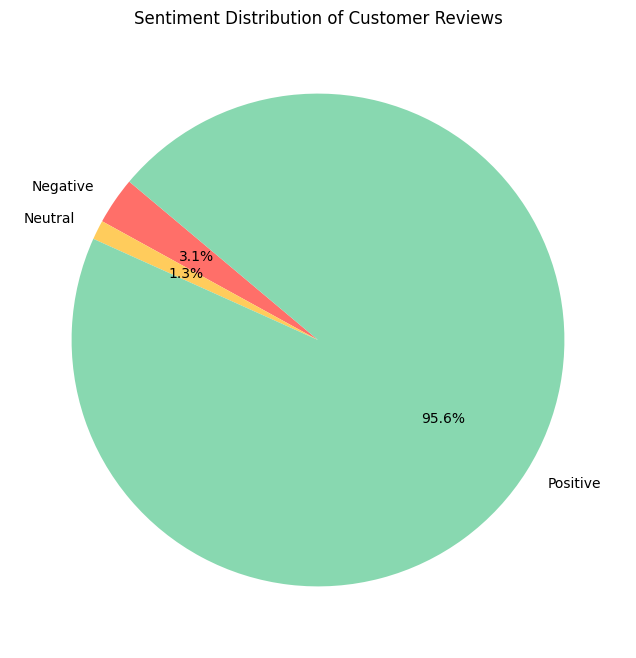

In [6]:
# Visualize sentiment analysis of the reviews as a pie chart in terms of pct
import matplotlib.pyplot as plt

# Different colour for each sentiment
colors = ['#ff6f69', '#ffcc5c', '#88d8b0']

plt.figure(figsize = (8, 8))
plt.pie(counts, labels=values, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Sentiment Distribution of Customer Reviews")
plt.show()

Evaluation of the sentiment analysis tool:

If we did not clean and preprocess the reviews; removing noise such as punctuation, special characters and non-English words, we will get 59 negative reviews, 54 neutral reviews, and 595 positive reviews.

If we cleaned and preprocessed the reviews, we will get 22 negative reviews, 9 neutral reviews, and 677 positive reviews.

Since, we found that such noise in text can hinder the effectiveness of sentiment analysis, we ran a preprocessing text function to remove the noise.

In [7]:
# Filter out negative and neutral reviews using VADER
problem_reviews = []
for i in range(len(reviews)):
    score = vader_analyzer.polarity_scores(clean(reviews[i]))
    if score['compound'] < 0.05:
            problem_reviews.append(reviews[i])

Below, we extract issues across negative and neutral reviews using Named Entity Recognition (NER) using Spacy, a Python-based Natural Language Processing (NLP) task that detects negative entities in each review. 

We considered running NER for all reviews, but it resulted in a very long list of issues. We kept to running NER for only negative and neutral reviews.

In [9]:
import spacy
from transformers import pipeline

# Load spaCy's NER model and a sentiment analysis pipeline for sentiment analysis for each entity in each review
nlp = spacy.load("en_core_web_sm")
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# A list to store common issues
issues = []
for review in problem_reviews:
    doc = nlp(review)
    for ent in doc.ents:
        # If sentiment of the entity is negative, add the keyword to the list
        sentiment = sentiment_pipeline(ent.text)[0]
        if sentiment['label'] == 'NEGATIVE':
            issues.append(ent.text)

print(issues)

["Don't", 'Bad', 'USB Cable', 'Sansui', 'Useless', 'Slow', 'MDR XB50AP.,boAt', 'Comparison', 'CHEAP', 'ANC', 'Substandard Copy', 'Pathetic', 'Ultra-Slow', 'Desigh', 'MI 5 Tab', 'Doesnt', 'less than 500', 'TWS']


As seen from the above insights,

The most common issue mentioned across these reviews is the quality of the product, such as the inability to work and its slow performance, seen by "Useless", "Ultra-Slow" and "Slow".

Other issues include that customers find the product to be a "cheap copy" of other better products, as seen by "Substandard copy", and do not enjoy the overall product, labelling it as "Pathetic" and "Bad". Another possible issue is the "Design".

As the dataset does not have any column specifically addressing customer feedback, common suggestions may be extracted from the reviews themselves.

Additionally, we implement the piece of code below to source for any reviews that talks about possible improvements to the product. This is an attempt to find any feedback among the reviews.

In [10]:
# Define words that hint on improving a product
suggestion_keywords = ["could", "should", "recommend", "would", "would like", "would be nice", "need", "improve", "improved"]

# Extract common suggestions
suggestions = []
for review in problem_reviews:
    doc = nlp(review)
    if any(keyword in review.lower() for keyword in suggestion_keywords):
        # Extract entities from suggestion sentences
        entities = [ent.text for ent in doc.ents]
        suggestions.append(review)

for suggestion in suggestions:
    print(f"Suggestion: {suggestion}")

Suggestion: Compatibility,Good one but voice not working propoer,Good but needs improvement in quality,Not strong,Works good,Waste of money,Works well,Don't buy... This remote
Suggestion: Install CSR Driver For Advanced Features + Stability (More Than Just Bluetooth),Thik h,Driver installation CD was missing from the package.,Not compatible for office usage,Spr,THIS IS MY 2ND ORDER,Waste of time & Money , Not recommend,Wrong product delivered.
Suggestion: कुछ खास नहीं बस ठीक ठाक है,Not good for regular use,pathetic battery back up,good,Does as it should,Very pathetic battery - never buy,Worth buy,Good, but 1.2 v please check when buying
Suggestion: When I placed the order I was in doubt whether it would work or not but it works very well,Very bad 😞😞,Remote very 👎 bad,Doesn’t works at all, material quality isn’t nearby the original one,No bluetooth
Suggestion: The price should be less than 500, not a very great product.,Good earphones,Average,Good earphone,Good for common men.,Nice head

We used Named Entity Recognition to identify suggestions using some suggestive keywords such as "recommend" and "would". Suggestions include lowering the price and improving the quality of the product.

If we refer to the list of common issues extracted from these reviews, common suggestions stemming from these issues include improving the performance and quality of the product; ensuring that the product works smoothly without any delays. Other suggestions are to improve compatibility with cables and own features.